In [3]:
import osmnx as ox
import pandas as pd
import geopandas as gd
import networkx as nx
from scgraph.geographs.marnet import marnet_geograph
from shapely import geometry
import time 
ox.settings.bidirectional_network_types = ["drive"]

''' Определение тегов '''
tags_port = {'industrial' : 'port'}
tags_aeroway = {'aeroway' : ['aerodrome','heliport', 'airstrip']}
tags_landuse = {'landuse' : 'railway'}
tags_build = {'building' : 'warehouse', 'amenity' : 'mailroom'}

''' Построение датафрейма нужных фич '''
def func_tags(tags, city):

    try:
        gdf = ox.features_from_place(city, tags).reset_index()
        gdf = gdf[['element_type', 'osmid']]
        gdf['n_osmid'] = gdf['element_type'].apply(lambda x: x[0]) + gdf['osmid'].astype(str)

        list_lat_lon = []
        for i in range(gdf.n_osmid.shape[0]):
            try:
                bb = ox.geocode_to_gdf(gdf.n_osmid.iloc[i], by_osmid=True)[['lat', 'lon']]
                list_lat_lon.append(bb.iloc[:])
            except ox._errors.InsufficientResponseError:
                list_lat_lon.append(pd.DataFrame({'lat': [None], 'lon': [None]}))
        dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
        gdf = gdf.merge(dfs, on=dfs.index).drop('key_0', axis=1)
        gdf = gdf[['lat', 'lon']]
        gdf['kind_of'] = list(tags.keys())[0]
        gdf = gdf.dropna().reset_index(drop=True)
        return gdf
    except ox._errors.InsufficientResponseError:
        return None

''' Построение графа, получение датафрейма фич и получение датафрейма долгот и широт для дальшейших вычислений '''
def create_graph_city(name_city, my_network_type = None, my_filter = None):
    full_df = pd.concat([func_tags(tags_port, name_city), 
                                    func_tags(tags_aeroway, name_city), 
                                    func_tags(tags_landuse, name_city), 
                                    func_tags(tags_build, name_city)], ignore_index=True)
    G = ox.graph_from_place(name_city, retain_all=True, simplify = True, network_type = my_network_type, custom_filter = my_filter)

    lat = list(full_df['lat'].values)
    lon = list(full_df['lon'].values)

    return full_df, G, lat, lon

''' Формирование датафрейма фич '''
def create_features_city(features_df, city_graph, lat, lon):
    features_df['new_nodes'] = ox.distance.nearest_nodes(city_graph, lon, lat)
    return features_df


''' Создание датафрейма со всеми маршрутами '''
def create_graph_route(input_graph, f_df):
    one_route = []
    for i in range(f_df.shape[0]):
        for j in range(i + 1, f_df.shape[0]):
            try:
                one_route.append(nx.shortest_path(input_graph, f_df['new_nodes'].iloc[i], f_df['new_nodes'].iloc[j]))
            except nx.NetworkXNoPath:
                pass
    route_df = pd.DataFrame({'route' : one_route})
    return route_df


''' Создание из нескольких LineString один MultiLineString - нужно для финального графа '''
def create_gdf_graph(nn, ee):
    ii = 0
    list_line = []
    list_multi_line = []
    for i in range(nn.shape[0] - 1):
        idx = nn.iloc[i + 1].new_nodes
        for j in range(ii, ee.index.get_level_values('u').shape[0]):
            if ee.index.get_level_values('u')[j] != idx:
                for k in range(len(ee.loc[ee.index.get_level_values('u')[j]]['geometry'].values)):
                    list_line.append(ee.loc[ee.index.get_level_values('u')[j]]['geometry'].values[k])
            else : 
                ii = j
        multi_line = geometry.MultiLineString(list_line)
        list_line = []
        list_multi_line.append(multi_line)
    return list_multi_line


''' Построение финального графа путей '''
def create_final_graph(arb_graph, route_df, feature_df):
    list_graphs = []
    for i in range(route_df.route.shape[0]):
        r = route_df['route'].values[i]

        rr = pd.DataFrame({'new_nodes' : r})
        rr['osmid'] = rr['new_nodes']
        rr = rr.set_index('osmid')
        rr['x'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['x'])
        rr['y'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['y'])
        rr

        edge_dict = {'u': rr.new_nodes[:-1].values, 'v': rr.new_nodes[1:].values, 'key': 0}
        edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
        edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

        graph_attrs = {"crs": "WGS84"}
        multi_digraph_aero = ox.convert.graph_from_gdfs(
            rr, edge_gdf, graph_attrs=graph_attrs)
        
        list_graphs.append(multi_digraph_aero)
        
    my_graph = list_graphs[0]
    for i in range(1, len(list_graphs)):
        my_graph = nx.compose_all([my_graph, list_graphs[i]])

    nodes, edges = ox.graph_to_gdfs(my_graph)
    list_nodes = list(feature_df['new_nodes'].values)
    n = nodes[nodes['new_nodes'].isin(list_nodes)]

    list_multiline = create_gdf_graph(n, edges)
    edge_dict = {'u': n.new_nodes[:-1].values, 'v': n.new_nodes[1:].values, 'key': 0}
    edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
    edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])
    edge_gdf['geometry'] = list_multiline
    graph_attrs = {"crs": "WGS84"}
    multi_digraph = ox.graph_from_gdfs(
        n, edge_gdf, graph_attrs=graph_attrs)
    
    return multi_digraph

In [4]:
# 定义 result 函数
def result(name_city):
    start_time = time.time()  # 记录开始时间

    graph_city = create_graph_city(name_city, my_network_type='drive')
    feature_df = create_features_city(*graph_city)
    ox.distance.add_edge_lengths(graph_city[1], edges=None)
    route_df = create_graph_route(graph_city[1], feature_df)
    final_graph_1_drive = create_final_graph(graph_city[1], route_df, feature_df)

    end_time = time.time()  # 记录结束时间
    elapsed_time = end_time - start_time  # 计算总耗时

    print(f"Total execution time: {elapsed_time:.2f} seconds")  # 输出总耗时

    return final_graph_1_drive

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 74.39 seconds


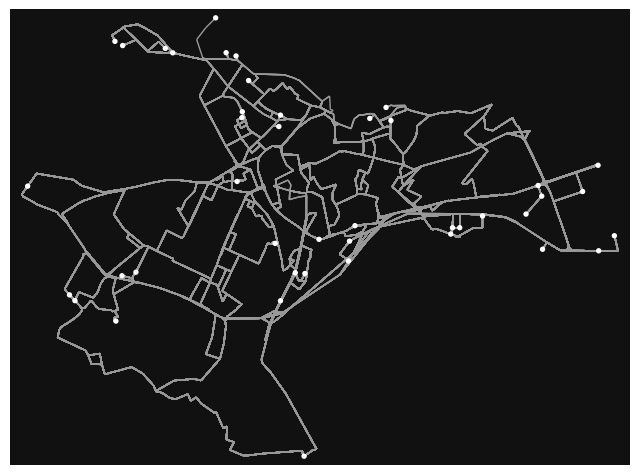

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
name_city = 'Tallin'
res_1 = result(name_city)
ox.plot_graph(res_1)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

Total execution time: 483.64 seconds


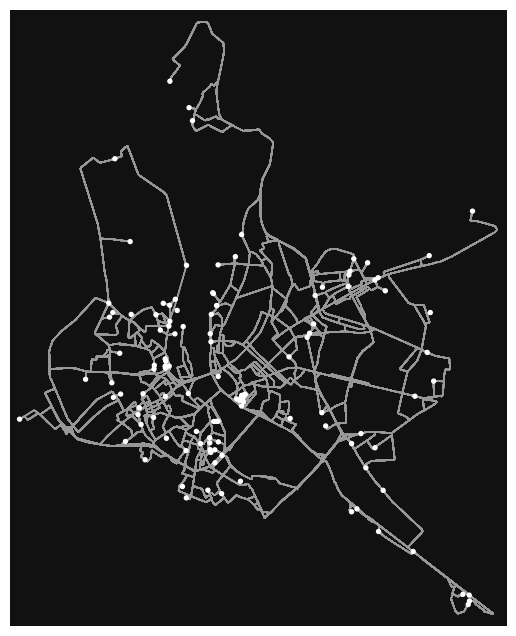

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [15]:
name_city = 'Riga'
res_2 = result(name_city)
ox.plot_graph(res_2)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an 

Total execution time: 19.40 seconds


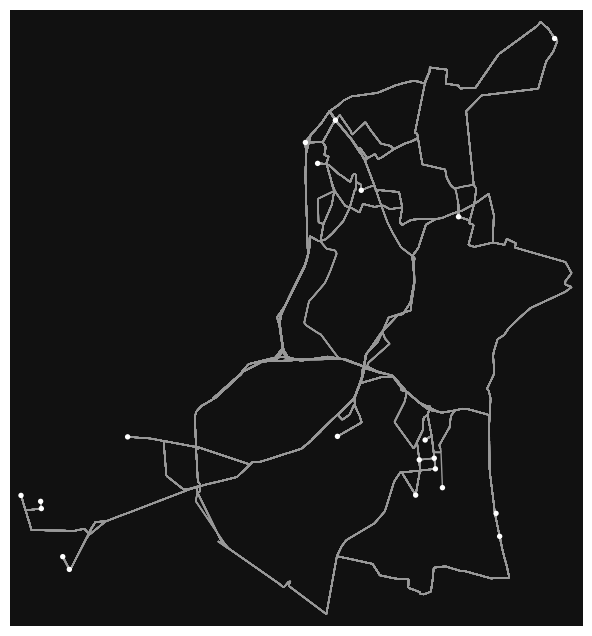

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [16]:
name_city = 'Vilnius'
res_3 = result(name_city)
ox.plot_graph(res_3)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 0.90 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


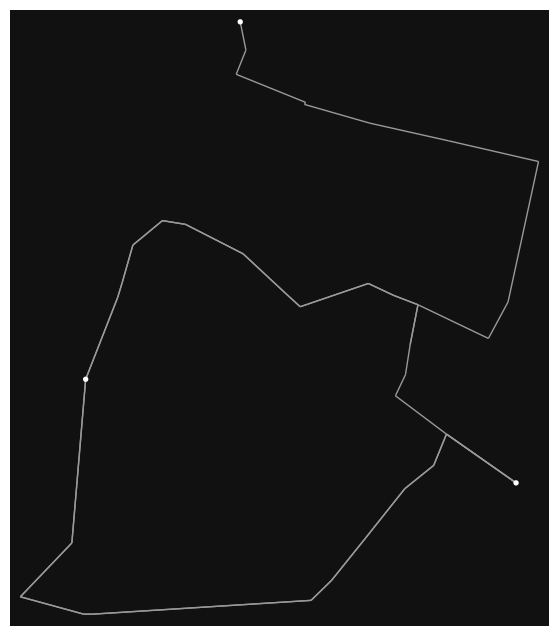

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [17]:
name_city = 'Strelna'
res_4 = result(name_city)
ox.plot_graph(res_4)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

Total execution time: 6300.98 seconds


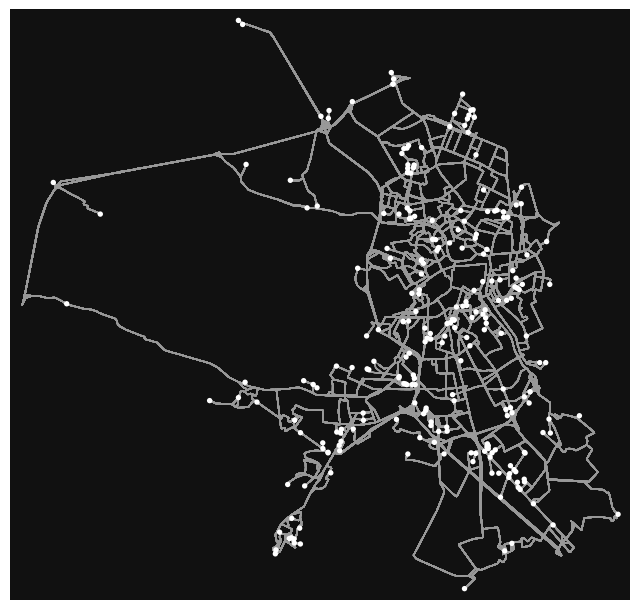

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [18]:
name_city = 'Saint Petersburg'
res_5 = result(name_city)
ox.plot_graph(res_5)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 22646.91 seconds


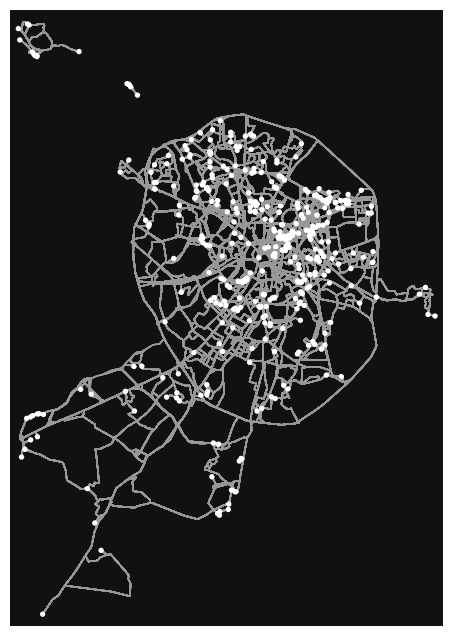

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
name_city = 'Moscow'
res_6 = result(name_city)
ox.plot_graph(res_6)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 246.42 seconds


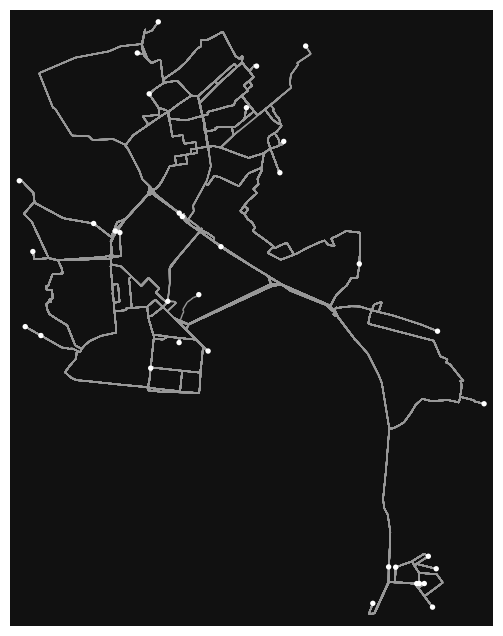

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
name_city = 'Novosibirsk'
res_7 = result(name_city)
ox.plot_graph(res_7)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 355.33 seconds


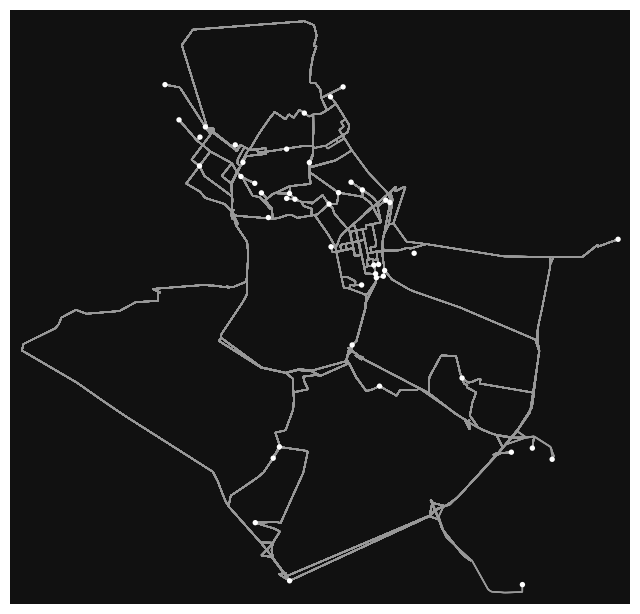

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
name_city = 'Yekaterinburg'
res_8 = result(name_city)
ox.plot_graph(res_8)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 62.87 seconds


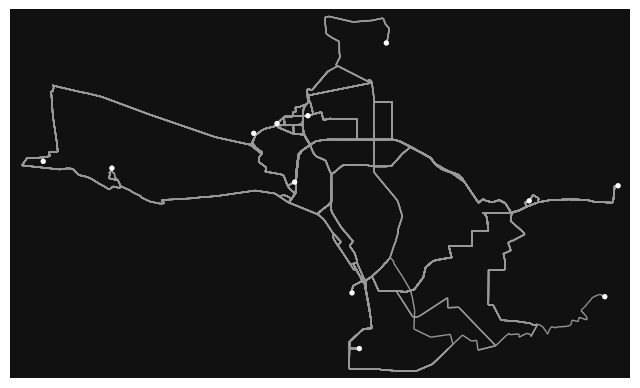

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
name_city = 'Kazan'
res_9 = result(name_city)
ox.plot_graph(res_9)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


Total execution time: 182.57 seconds


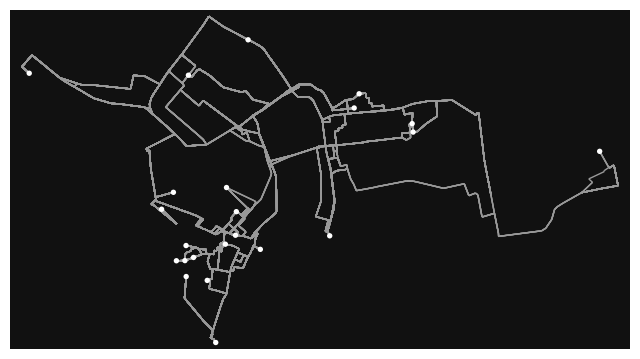

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
name_city = 'Omsk'
res_10 = result(name_city)
ox.plot_graph(res_10)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an 

Total execution time: 78.04 seconds


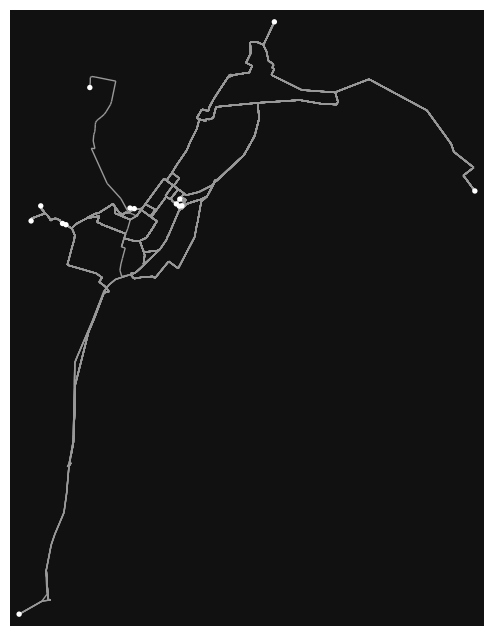

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:
name_city = 'Ufa'
res_11 = result(name_city)
ox.plot_graph(res_11)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an 

Total execution time: 330.71 seconds


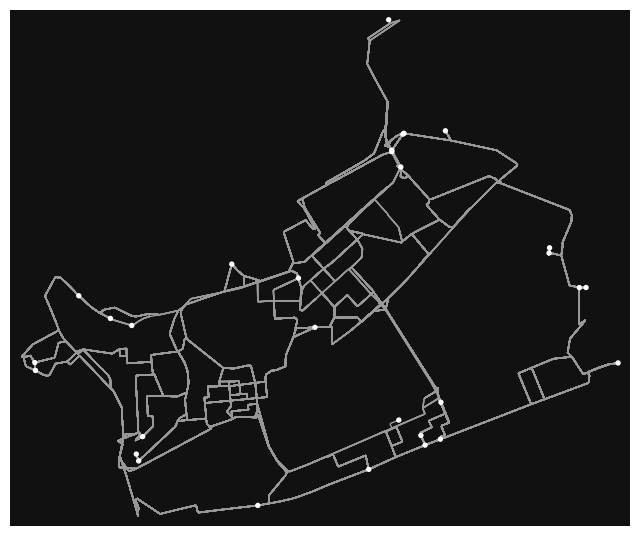

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [11]:
name_city = 'Krasnoyarsk'
res_12 = result(name_city)
ox.plot_graph(res_12)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 109.46 seconds


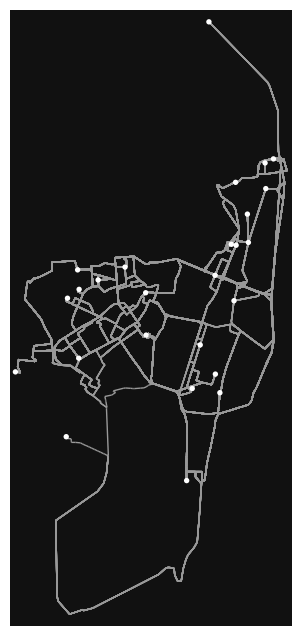

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [12]:
name_city = 'Voronezh'
res_13 = result(name_city)
ox.plot_graph(res_13)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 85.22 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


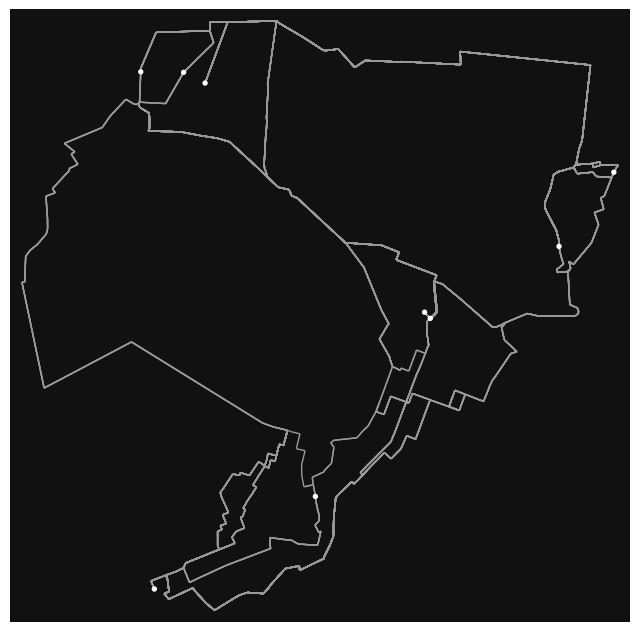

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [13]:
name_city = 'Saratov'
res_14 = result(name_city)
ox.plot_graph(res_14)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 64.65 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


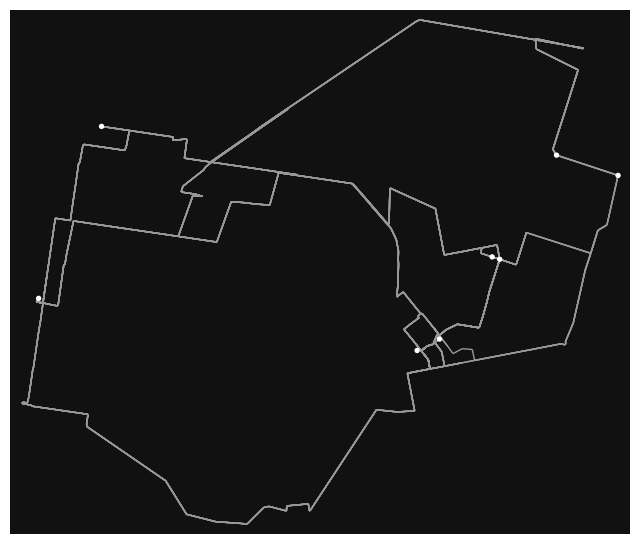

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
name_city = 'Togliatti'
res_15 = result(name_city)
ox.plot_graph(res_15)

In [16]:
name_city = 'Vologda'
res_16 = result(name_city)
ox.plot_graph(res_16)

D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 78 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 78 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\ast.py:587: Deprecatio

ConnectTimeout: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /lookup?format=json&polygon_geojson=1&osm_ids=w668018223 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001FD9973E300>, 'Connection to nominatim.openstreetmap.org timed out. (connect timeout=180)'))

In [17]:
name_city = 'Perm'
res_17 = result(name_city)
ox.plot_graph(res_17)

ConnectTimeout: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /lookup?format=json&polygon_geojson=1&osm_ids=w880300215 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001FD999F4440>, 'Connection to nominatim.openstreetmap.org timed out. (connect timeout=180)'))

In [ ]:
name_city = 'Barnaul'
res_18 = result(name_city)
ox.plot_graph(res_18)

In [ ]:
name_city = 'Samara'
res_19 = result(name_city)
ox.plot_graph(res_19)

In [ ]:
name_city = 'Vladivostok '
res_20 = result(name_city)
ox.plot_graph(res_20)

Moscow - 莫斯科
Saint Petersburg - 圣彼得堡
Novosibirsk - 新西伯利亚
Yekaterinburg - 叶卡捷琳堡
Nizhny Novgorod - 下诺夫哥罗德
Kazan - 喀山
Chelyabinsk - 切尔亚宾斯克
Samara - 萨马拉
Omsk - 鄂木斯克
Rostov-on-Don - 顿河畔罗斯托夫
Ufa - 乌法
Krasnoyarsk - 克拉斯诺亚尔斯克
Voronezh - 沃罗涅日
Saratov - 萨拉托夫
Togliatti - 托木拉季
Vologda - 沃洛格达
Perm - 彼尔姆
Barnaul - 巴尔瑙尔
Tyumen - 秋明
Vladivostok - 海参崴
Irkutsk - 伊尔库茨克
Khabarovsk - 哈巴罗夫斯克
Orenburg - 鄂伦春斯克
Naberezhnye Chelny - 纳巴列日内切尔尼
Novokuznetsk - 新库兹涅茨克
Chita - 切塔
Astrakhan - 阿斯特拉罕
Kaliningrad - 加里宁格勒
Ryazan - 梁赞
Tver - 特维尔
Lipetsk - 利佩茨克
Ivanovo - 伊万诺沃
Bratsk - 布拉茨克
Ulyanovsk - 乌里扬诺夫斯克
Arkhangelsk - 阿尔汉格尔斯克
Syktyvkar - 西刻季夫卡
Tomsk - 汤姆斯克
Nizhnekamsk - 下卡姆斯克
Mytishchi - 米季什契
Kirov - 基洛夫
Kurgan - 库尔干
Surgut - 苏尔古特
Cherepovets - 切列波韦茨
Sochi - 索契
Naberezhnyye Chelny - 纳巴列日内切尔尼（重复）
Dmitrov - 德米特罗夫
Veliky Novgorod - 大诺夫哥罗德
Elabuga - 埃拉布加
Zhukovsky - 朱可夫斯基
Votkinsk - 沃特金斯克

In [ ]:
#nodes_1, edges_1 = ox.graph_to_gdfs(res_1)
#nodes_2, edges_2 = ox.graph_to_gdfs(res_2)
#nodes_3, edges_3 = ox.graph_to_gdfs(res_3)
#nodes_4, edges_4 = ox.graph_to_gdfs(res_4)

#nodes_1.to_csv('data/nodes_tallin.csv')
#edges_1.to_csv('data/edges_tallin.csv')
#nodes_2.to_csv('data/nodes_riga.csv')
#edges_2.to_csv('data/edges_riga.csv')
#nodes_3.to_csv('data/nodes_vilnius.csv')
#edges_3.to_csv('data/edges_vilnius.csv')
#nodes_4.to_csv('data/nodes_strelna.csv')
#edges_4.to_csv('data/edges_strelna.csv')